In [3]:

import json
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from common.utils.utils import estimate_solution_score
from analysis.utils.process import process_moves
from common.models.network import Network

In [4]:
networks_path = Path("../data/24_02_04")
network_data = json.load(open(networks_path / "networks.json"))

solutions = {
    "myopic": json.load(open(networks_path / "solution__myopic.json")),
    "m1": json.load(open(networks_path / "machine_solutions" / "0.json")),
    "random": json.load(open(networks_path / "solution__random.json")),
    "take_loss": json.load(open(networks_path / "solution__take_loss.json")),
}

def key_solutions(solutions):
    return {s["network_id"]: s for s in solutions}

solutions_by_network_id = {k: key_solutions(v) for k, v in solutions.items()}

In [5]:
scores = []
moves = []
for network in network_data:
    n = Network(**network)
    n_id = n.network_id
    for s_type in solutions.keys():
        solution = solutions_by_network_id[s_type][n_id]
        score = estimate_solution_score(n, moves=solution['moves'], n_steps=10)
        scores.append({
            "network_id": n_id,
            "type": s_type,
            "score": score
        })
        ms = process_moves(network, solution['moves'])
        ms = [{**m, "type": s_type, "network_id": n_id} for m in ms]
        moves.extend(ms)

scores_df = pd.DataFrame(scores)
moves_df = pd.DataFrame(moves)

<Axes: xlabel='type', ylabel='network_id-move_idx'>

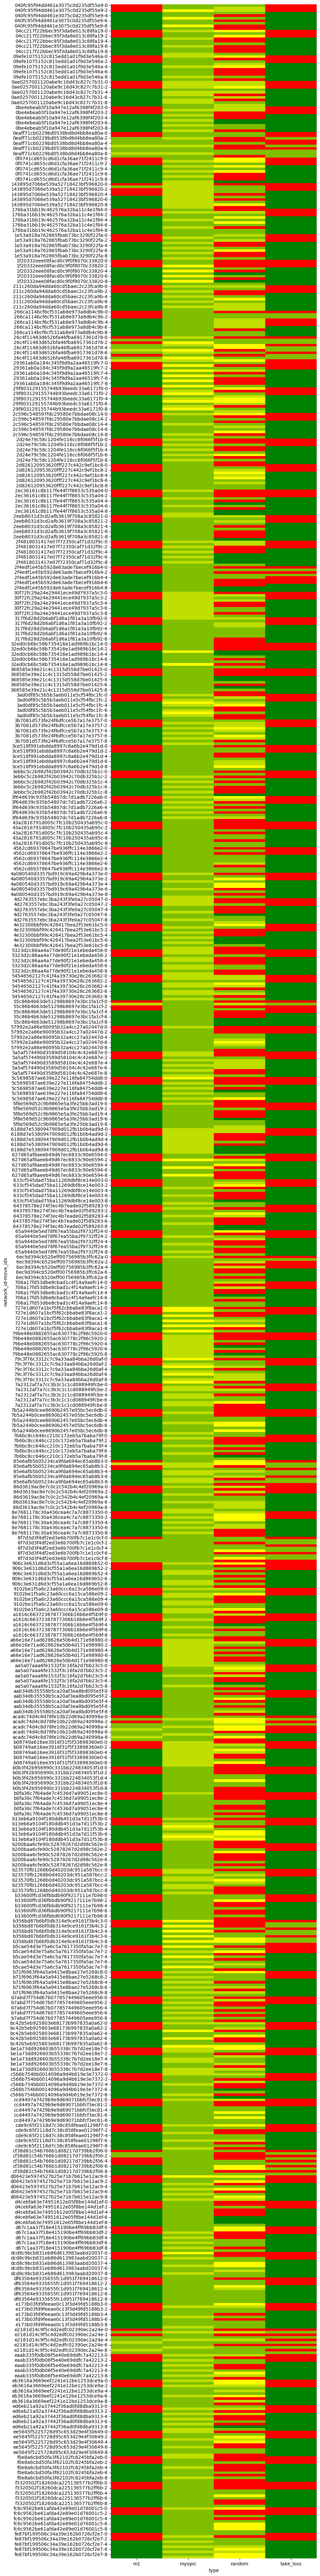

In [6]:
moves_matrix = moves_df.pivot_table(index=['network_id', 'move_idx'], columns=['type'], values='reward')
n_sessions = len(moves_matrix.index.levels[0])

# drop all index but session_name
# moves_matrix = moves_matrix.sort_index(level=[1,2], ascending=True)
# moves_matrix = moves_matrix.reset_index(level=[0,2], drop=True)


# Original nodes and colors
nodes = np.array([-50, 0, 400])
colors = ["red", "yellow", "green"]

# Normalize nodes to be in the range [0, 1]
norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

plt.figure(figsize=(8, n_sessions))

sns.heatmap(moves_matrix, cmap=cmap, cbar=False, vmin=-50, vmax=400)

In [9]:
scores_df = scores_df.pivot_table(index="network_id", columns="type", values="score")

In [10]:
scores_df['m1-myopic'] = scores_df['m1'] - scores_df['myopic']
scores_df['m1-random'] = scores_df['m1'] - scores_df['random']
scores_df['m1-take_loss'] = scores_df['m1'] - scores_df['take_loss']
scores_df['take_loss-myopic'] = scores_df['take_loss'] - scores_df['myopic']

In [11]:
scores_df.mean()

type
m1                  2563.5
myopic              1570.0
random               792.5
take_loss           2479.5
m1-myopic            993.5
m1-random           1771.0
m1-take_loss          84.0
take_loss-myopic     909.5
dtype: float64

In [12]:
(scores_df < 0).mean()

type
m1                  0.00
myopic              0.00
random              0.00
take_loss           0.00
m1-myopic           0.05
m1-random           0.00
m1-take_loss        0.02
take_loss-myopic    0.08
dtype: float64